# VacationPy
----

#### Note
* Keep an eye on your API usage. Use https://developers.google.com/maps/reporting/gmp-reporting as reference for how to monitor your usage and billing.

* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import json
import os

# Import API key
from api_keys import g_key

# Save image on notebook
from IPython.display import Image

### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [2]:
file_path = "../WeatherPy/cities.csv"
cities_weather_df = pd.read_csv(file_path)
# cities_weather_df
del cities_weather_df["Unnamed: 0"]
cities_weather_df

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,rikitea,22.0,PF,1.620879e+09,78.0,-23.1203,-134.9692,77.40,17.67
1,kochi,100.0,IN,1.620879e+09,76.0,9.9399,76.2602,82.31,3.71
2,codrington,100.0,AU,1.620879e+09,71.0,-38.2667,141.9667,52.68,18.19
3,dwarka,17.0,IN,1.620878e+09,70.0,22.2394,68.9678,85.30,18.37
4,port moresby,100.0,PG,1.620879e+09,74.0,-9.4431,147.1797,82.98,4.83
...,...,...,...,...,...,...,...,...,...
566,terrak,100.0,NO,1.620879e+09,97.0,65.0870,12.3715,44.47,2.46
567,kurmanayevka,34.0,RU,1.620879e+09,48.0,52.5093,52.0675,67.41,12.82
568,luang prabang,9.0,LA,1.620879e+09,50.0,19.8856,102.1347,93.58,2.62
569,ishigaki,40.0,JP,1.620879e+09,79.0,24.3448,124.1572,85.78,16.11


### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [3]:
gmaps.configure(g_key)

In [4]:
locations = cities_weather_df[["Lat", "Lng"]]
humidity = cities_weather_df["Humidity"].astype(float)
max_humidity = max(humidity)

In [5]:
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=humidity, 
                                 dissipating=False, max_intensity=max_humidity, 
                                 point_radius=3.5)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

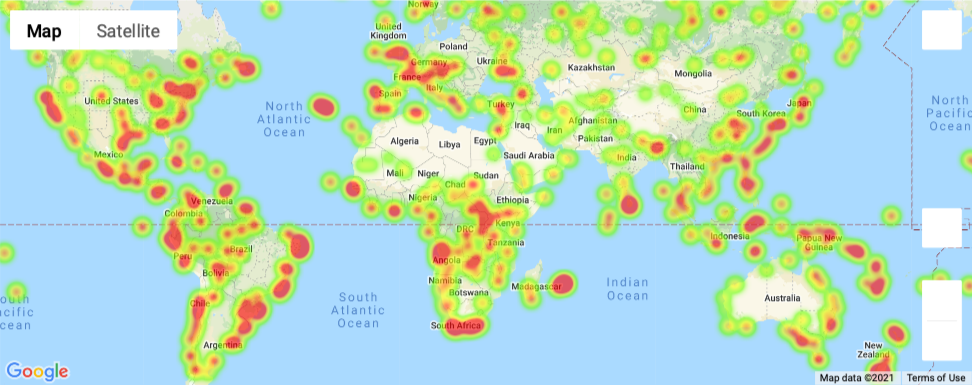

In [6]:
Image("humidity_heatmap.png")

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [7]:
# Perfect temperature (Between 70 and 80 Degrees)
perfect_conditions = cities_weather_df[(cities_weather_df["Max Temp"] >70) 
                                       & (cities_weather_df["Max Temp"] < 80) 
                                       & (cities_weather_df["Wind Speed"] < 10) 
                                       & (cities_weather_df["Cloudiness"] == 0)]

perfect_conditions

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
11,walvis bay,0.0,NaN,1.620879e+09,32.0,-22.9575,14.5053,73.98,6.44
40,saint-pierre,0.0,RE,1.620879e+09,69.0,-21.3393,55.4781,74.64,3.44
186,henties bay,0.0,NaN,1.620879e+09,44.0,-22.1160,14.2845,71.20,5.26
201,sonoita,0.0,MX,1.620879e+09,17.0,31.8500,-112.8333,76.08,3.83
261,manaus,0.0,BR,1.620879e+09,94.0,-3.1019,-60.0250,76.68,0.00
347,namibe,0.0,AO,1.620879e+09,67.0,-15.1961,12.1522,72.90,2.68
367,innisfail,0.0,AU,1.620879e+09,73.0,-17.5333,146.0333,79.70,7.27
444,flinders,0.0,AU,1.620879e+09,49.0,-34.5833,150.8552,73.80,4.14
455,coffs harbour,0.0,AU,1.620879e+09,68.0,-30.3000,153.1333,71.55,8.05
489,gold coast,0.0,AU,1.620879e+09,43.0,-28.0000,153.4333,77.00,8.01


### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [8]:
hotel_df = pd.DataFrame(perfect_conditions)
hotel_df["Hotel Name"] = ""
hotel_df

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed,Hotel Name
11,walvis bay,0.0,NaN,1.620879e+09,32.0,-22.9575,14.5053,73.98,6.44,
40,saint-pierre,0.0,RE,1.620879e+09,69.0,-21.3393,55.4781,74.64,3.44,
186,henties bay,0.0,NaN,1.620879e+09,44.0,-22.1160,14.2845,71.20,5.26,
201,sonoita,0.0,MX,1.620879e+09,17.0,31.8500,-112.8333,76.08,3.83,
261,manaus,0.0,BR,1.620879e+09,94.0,-3.1019,-60.0250,76.68,0.00,
347,namibe,0.0,AO,1.620879e+09,67.0,-15.1961,12.1522,72.90,2.68,
367,innisfail,0.0,AU,1.620879e+09,73.0,-17.5333,146.0333,79.70,7.27,
444,flinders,0.0,AU,1.620879e+09,49.0,-34.5833,150.8552,73.80,4.14,
455,coffs harbour,0.0,AU,1.620879e+09,68.0,-30.3000,153.1333,71.55,8.05,
489,gold coast,0.0,AU,1.620879e+09,43.0,-28.0000,153.4333,77.00,8.01,


In [9]:
params = {"radius": 5000,
          "types": "hotel",
          "keyword": "hotel",
          "key": g_key}

base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

for index, row in hotel_df.iterrows():
    latitude = row["Lat"]
    longitude = row["Lng"]
    params['location'] = f"{latitude},{longitude}"
    
    city = row["City"]
    
    print(f"Retrieving Hotel Name for City ID {index}: {city}")
    response = requests.get(base_url, params=params)
    data = response.json()
    
#     print(json.dumps(data, indent=4))

    try:
        hotel_df.loc[index, "Hotel Name"] = data["results"][0]["name"]
    except:
        print("Missing field/result... skipping.")
        
    print("-----------------")

Retrieving Hotel Name for City ID 11: walvis bay
-----------------
Retrieving Hotel Name for City ID 40: saint-pierre
-----------------
Retrieving Hotel Name for City ID 186: henties bay
-----------------
Retrieving Hotel Name for City ID 201: sonoita
-----------------
Retrieving Hotel Name for City ID 261: manaus
-----------------
Retrieving Hotel Name for City ID 347: namibe
-----------------
Retrieving Hotel Name for City ID 367: innisfail
-----------------
Retrieving Hotel Name for City ID 444: flinders
-----------------
Retrieving Hotel Name for City ID 455: coffs harbour
-----------------
Retrieving Hotel Name for City ID 489: gold coast
-----------------
Retrieving Hotel Name for City ID 535: jalu
-----------------


In [10]:
# Checking hotel_df
hotel_df

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed,Hotel Name
11,walvis bay,0.0,NaN,1.620879e+09,32.0,-22.9575,14.5053,73.98,6.44,Protea Hotel by Marriott Walvis Bay Pelican Bay
40,saint-pierre,0.0,RE,1.620879e+09,69.0,-21.3393,55.4781,74.64,3.44,Hôtel Le Saint-Pierre
186,henties bay,0.0,NaN,1.620879e+09,44.0,-22.1160,14.2845,71.20,5.26,De Duine Hotel
201,sonoita,0.0,MX,1.620879e+09,17.0,31.8500,-112.8333,76.08,3.83,Hotel Excelsior
261,manaus,0.0,BR,1.620879e+09,94.0,-3.1019,-60.0250,76.68,0.00,Hotel Villa Amazônia
347,namibe,0.0,AO,1.620879e+09,67.0,-15.1961,12.1522,72.90,2.68,Hotel Chik Chik Namibe
367,innisfail,0.0,AU,1.620879e+09,73.0,-17.5333,146.0333,79.70,7.27,Tropical Lodge
444,flinders,0.0,AU,1.620879e+09,49.0,-34.5833,150.8552,73.80,4.14,Lakeview Hotel Motel
455,coffs harbour,0.0,AU,1.620879e+09,68.0,-30.3000,153.1333,71.55,8.05,Ramada Resort by Wyndham Coffs Harbour
489,gold coast,0.0,AU,1.620879e+09,43.0,-28.0000,153.4333,77.00,8.01,Hilton Surfers Paradise Hotel & Residences


In [ ]:
# Drop empty rows in hotel_df
# nan_value = float("NaN")
# hotel_df.replace("", nan_value, inplace=True)
# hotel_df.dropna(inplace=True)
# hotel_df

In [11]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["Lat", "Lng"]]

In [12]:
# Add marker layer ontop of heat map
hotel_markers = gmaps.marker_layer(locations, info_box_content=hotel_info)
fig.add_layer(hotel_markers)
fig


Figure(layout=FigureLayout(height='420px'))

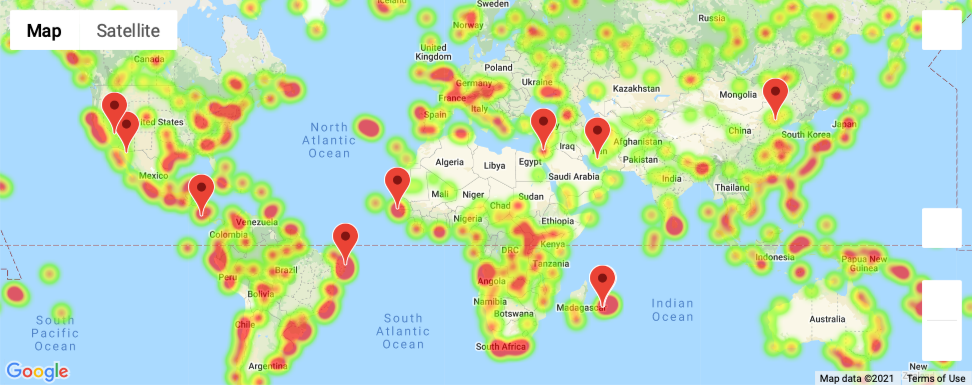

In [14]:
Image("hotel_map.png")